In [10]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_addons as tfad
import matplotlib.pyplot as plt

In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 12.6MB/s 


In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169009152/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [116]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class MLPSingle(tf.keras.Model):
  def __init__(self,units,dropout_rate):
    super(MLPSingle,self).__init__()
    self.fc = layers.Dense(units,activation=tf.nn.gelu)
    self.drop = layers.Dropout(dropout_rate)

  def call(self,x):
    x = self.fc(x)
    x = self.drop(x)
    return x


class MLP(tf.keras.Model):
  def __init__(self,hidden_units,dropout_rate=0.5):
    super(MLP,self).__init__()
    self.lays = []
    for units in hidden_units:
      self.lays.append(MLPSingle(units,dropout_rate))

  def call(self,x):
    for layer in self.lays: 
      x = layer(x)
    return x

In [117]:
class Patches(layers.Layer):
    def __init__(self,size):
      super(Patches,self).__init__()
      self.size = size 
    
    def call(self,img):
      batch_size = tf.shape(img)[0]
      patches = tf.image.extract_patches(img,[1,self.size,self.size,1],
                                         [1,self.size,self.size,1],
                                         [1,1,1,1],
                                         padding='VALID')
      patch_dim = patches.shape[-1]
      patches = tf.reshape(patches,[batch_size,-1,patch_dim])
      return patches

    def plot(self,image,resized_image):
      plt.figure(figsize=(4, 4))
      
      plt.imshow(image.astype("uint8"))
      plt.axis("off")
      patches = self.call(resized_image)

      print(f"Image size: {image_size} X {image_size}")
      print(f"Patch size: {patch_size} X {patch_size}")
      print(f"Patches per image: {patches.shape[1]}")
      print(f"Elements per patch: {patches.shape[-1]}")

      n = int(np.sqrt(patches.shape[1]))
      plt.figure(figsize=(4, 4))
      for i, patch in enumerate(patches[0]):
          ax = plt.subplot(n, n, i + 1)
          patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
          plt.imshow(patch_img.numpy().astype("uint8"))
          plt.axis("off")



Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


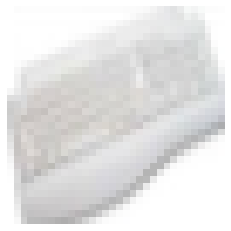

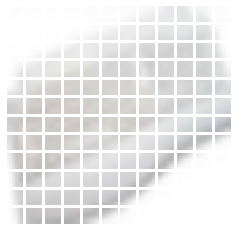

In [111]:
#call patch plot
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
          tf.convert_to_tensor([image]), size=(image_size, image_size)
      )
patch = Patches(patch_size)
patch.plot(image,resized_image)

In [118]:
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = layers.Dense(units=projection_dim)
    self.pose_embedding = layers.Embedding(input_dim=num_patches,output_dim=self.projection_dim)

  def call(self,patch):
    positions = tf.range(0,self.num_patches,1)
    encoded = self.projection(patch) + self.pose_embedding(positions)
    return encoded

In [119]:
class TransformerBlock(tf.keras.Model):
  def __init__(self,tf_hidden,hidden_units):
    super(TransformerBlock,self).__init__()
    #norm blocks are only in call
    self.tf_hidden = tf_hidden
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)
    self.add = layers.Add()
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
    self.mlp = MLP(hidden_units)


  def call(self,encoded_patches):
    x1 = self.norm1(encoded_patches)
    attention_output = self.attention(x1,x1)
    #skip connection 1
    x2 = self.add([x1,x1])
    x3 = self.norm2(x2)
    x3 = self.mlp(x3)
    #skip connection 2
    encoded_patches = self.add([x3,x2])
    return encoded_patches

In [129]:
def VIT():
  inputs = layers.Input(shape=input_shape)
  #Augmentation 
  augmented = data_augmentation(inputs)
  #Create the patches 
  patches = Patches(patch_size)(augmented)
  #Encode Patches
  encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)
  block = TransformerBlock(transformer_units,transformer_units)
  mlp = MLP(mlp_head_units)
  
  for _ in range(transformer_layers):
    encoded_patches = block(encoded_patches)
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  #mlp again 
  features = mlp(representation)
  logits = layers.Dense(num_classes)(features)
  model = tf.keras.Model(inputs=inputs,outputs=logits)

  return model

In [130]:
model = VIT()

In [131]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_38[0][0]                   
__________________________________________________________________________________________________
patches_44 (Patches)            (None, None, 108)    0           data_augmentation[37][0]         
__________________________________________________________________________________________________
patch_encoder_37 (PatchEncoder) (None, 144, 64)      16192       patches_44[0][0]                 
____________________________________________________________________________________________

In [ ]:
def run_experiment(model):
    optimizer = tfad.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = VIT()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 549s 3s/step - loss: 4.8801 - accuracy: 0.0272 - top-5-accuracy: 0.1081 - val_loss: 3.9468 - val_accuracy: 0.0958 - val_top-5-accuracy: 0.2938
Epoch 2/100
 19/176 [==>...........................] - ETA: 8:51 - loss: 4.1503 - accuracy: 0.0681 - top-5-accuracy: 0.2282